<a href="https://colab.research.google.com/github/pharringtonp19/mecon/blob/main/notebooks/problem_sets/solutions/Problem_Set_Six_Solutions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#@title Imports { display-mode: "form" }
%%capture 
!pip install jaxopt
import jax 
jax.config.update("jax_enable_x64", True)
import jax.numpy as jnp 
import matplotlib.pyplot as plt 
from functools import partial 

We assume that workers differ in some way which we denote by $t$. We representa this mathematically by saying that the type of the work (t) follows a uniform distribution **parameterized** by $(m,c)$ as follows:

$$t \sim U(m - 3c, m + 3c)$$

We construct a function that allows us to sample from this distribution below.

In [2]:
def sample_worker_type(m, c, key): 
  return jax.random.uniform(key, minval=m-c*3, maxval=m+c*3)

Let's partially evalute the above function at $m=5$ and $c=2$ and refer to this function as $f$. By doing so, we now sample multiple individuals from the same distribution

In [3]:
f = partial(sample_worker_type, .5, .1) # Partially Evaluate Function 

We know that if we pass in a `key` to f, we will sample one worker's type. To sample multiple individuals we proceed as follows:


1.   Vectorize the function $f$
2.   Pass in a vector of keys



In [4]:
vector_of_keys = jax.random.split(jax.random.PRNGKey(0), 2000)
vectorized_f = jax.vmap(f)
samples = vectorized_f(vector_of_keys)

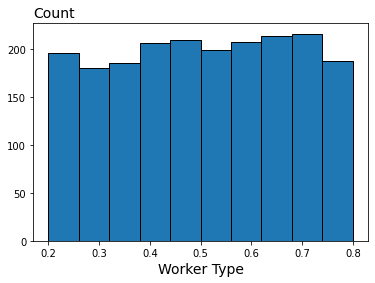

In [5]:
#@title Samples of Workers' Types { display-mode: "form" }
plt.hist(samples, edgecolor='black')
plt.xlabel('Worker Type', size=14)
plt.title('Count', size=14, loc='left') 
plt.show()

\begin{align*}
\textrm{Cost_of_license}(t) = c_0 t^{-a} + c_1
\end{align*}

In [16]:
#@title Cost of License { display-mode: "form" }
def cost_license(c0, c1, a, t):
  """ 
  - c0, c1, a parameterize the cost function of a getting a license
  - t denotes the worker's type
  """
  return c0 + c1*(1/(t**a))

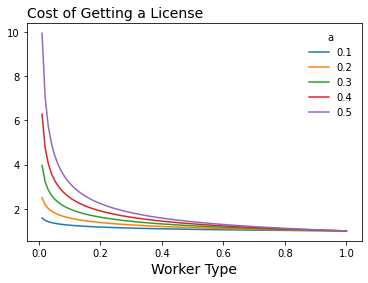

In [17]:
#@title Cost of License { display-mode: "form" }
c0, c1 = 0., 1. 
ws = jnp.linspace(0, 1, 100)
for i in jnp.linspace(0.1, 0.5, 5):
  ys = jax.vmap(partial(cost_license, c0, c1, i))(ws)
  plt.plot(ws, ys, label=i)
plt.title('Cost of Getting a License', loc='left', size=14)
plt.xlabel('Worker Type',size=14)
plt.legend(frameon=False, title='a')
plt.show()

Let's assume that a firm only observes wether or not an individual has a license. Then the wage offered by the firm can be expressed as follows:

\begin{align*}
\textrm{wage}(\textrm{license}) = \begin{cases} w0 \quad \textrm{if} \ \textrm{license} = 0 \\ 
w1 \quad \textrm{if} \ \textrm{license} = 1\end{cases}
\end{align*}

**Note**: The domain for the wage function is a finite set (there are only two elments in it $\{0, 1\}$), therefore we can represent this function as a vector where $w[0]$ can be thought of as evaluating the wage function at $0$. 

### **Question 1**:
Write down the optimal action of the worker as a function of the parameters of the cost of license function, the wage vector and worker type


In [20]:
def optimal_action_worker(c0, c1, a, w, t):
  return jnp.where(w[1] - cost_license(c0, c1, a, t) > w[0], 1., 0. )

### **Question 2**:

Play around with the parameters of the the cost and wage functions to get some intuition for how the influence the optimal action



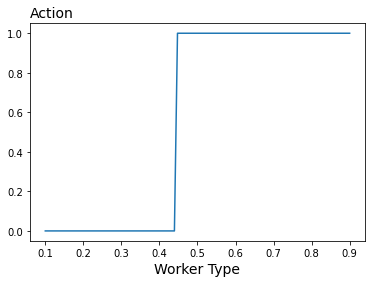

In [21]:
#@title Graph of Optimal Action { display-mode: "form" }
c0, c1, a = 0., 1., 0.5   # Parameters for the Cost of Effort Function
w = jnp.array([10.5, 12])    # Wage function

# Vectorized Action Function
action_fn = partial(optimal_action_worker, c0, c1, a, w)

# Vector of Worker Types
ts = jnp.linspace(0.1, 0.9, 100)

# Corresponding Action for Each Worker Type 
actions = jax.vmap(action_fn)(ts)

# Graph
plt.plot(ts, actions)
plt.title('Action', size=14, loc='left')
plt.xlabel('Worker Type', size=14)
plt.show()

### **Question 3**

We want to determine the worker type where the worker would be indifferent between getting and not getting a license. 

We can implicitly define this value as the root of a function $F$. Please define $F$. 

In [22]:
#@title Solving the Root
from jaxopt import Bisection

def F(t, c0, c1, a, w):
  return (w[1] - cost_licsense(c0,c1,a, t)) - w[0]

c0, c1, a = 0., 1., 0.5   # Parameters for the Cost of Effort Function
w = jnp.array([10.5, 12])    # Wage function

def root(c0, c1, a, w):
  bisec = Bisection(optimality_fun=F, lower=0., upper=1.)
  return bisec.run(c0=c0, c1=c1, a=a, w=w).params

root(c0, c1, a, w)

DeviceArray(0.44444275, dtype=float64)

#**The Firm Problem**
We begin by writing identifying the choice set of the firm and the objective function. 
\begin{align*}
\underset{\textrm{wage_fn}}{\textrm{maximize}} \ &\mathbb{E}\big[\textrm{Profit}(\textrm{wage_fn})\big] 
\end{align*}

Expectations are taken with respect to some distribution. In this context, the underlying distribution is the the distribution over worker types. 

\begin{align*}
t \sim U[m-3c, m + 3c] 
\end{align*}

That is: 

$$t \longmapsto \textrm{Profit}(\textrm{wage_fn})(t)$$

We can express $\textrm{Profit}(\textrm{wage_fn})$ as the addition of two random variables.

\begin{align*}
t \longmapsto \textrm{Profit}(\textrm{wage_fn})(t) &= \textrm{Revenue}(\textrm{wage_fn})(t) - \textrm{Cost}(\textrm{wage_fn})(t)
\end{align*}

We can express $\textrm{Revenue}(\textrm{wage_fn})$ as follows

\begin{align*}
t \longmapsto \textrm{Revenue}(\textrm{wage_fn})(t) &= D^{-1}(\textrm{Quantity}(\textrm{wage_fn})(t))\textrm{Quantity}(\textrm{wage_fn})(t) \\ 
\end{align*}

We can express $\textrm{Quantity}(\textrm{wage_fn})$ as follows

\begin{align*}
t \longmapsto \textrm{Quantity}(\textrm{wage_fn})(t) := \begin{cases} g(t) \quad \textrm{wage_fn}(l^*(\textrm{wage_fn},t)) - \textrm{cost_license}(t)l^*(\textrm{wage_fn},t) >= \textrm{outside_wage_fn}(l^*(\textrm{wage_fn},t))\\ 
0 \quad \textrm{otherwise}
\end{cases}
\end{align*}











We can express $\textrm{Cost}(\textrm{wage_fn})$ as follows
\begin{align*}
t ⟼ \textrm{Cost}(\textrm{wage_fn})(t) =  \begin{cases}\textrm{wage_fn}(0) \quad \textrm{if} \ l^*(\textrm{wage_fn}, t) = 0 \\ 
\textrm{wage_fn}(1) \quad \textrm{if} \ l^*(\textrm{wage_fn}, t) = 1 \\ 
\end{cases}
\end{align*}



In [23]:
l_star = lambda w, t: optimal_action_worker(c0, c1, a, w, t)

In [74]:
def g(t):
  """Productivity Function"""
  return t 

# Outside Wage Function
outside_wage = jnp.array([2., 4.])

In [75]:
def work(w, t):
  license = l_star(w, t)
  net_gain = jnp.where(license==1, w[1] - cost_license(c0, c1, a, t) - outside_wage[1], w[0] - outside_wage[0])
  return jnp.where(net_gain>=0., 1., 0.)

In [76]:
def cost(w, t):
  """Cost Function"""
  cost_to_employ = jnp.where(l_star(w, t) ==1., w[1], w[0])
  return jnp.where(work(w, t) ==1., cost_to_employ, 0.)

In [77]:
def quantity(w, t):
  return jnp.where(work(w, t) ==1., g(t), 0.)

In [78]:
def price(q):
  return 15. 

In [79]:
def revenue(w, t):
  q = quantity(w, t)
  return price(q)*q # Why don't we need to multiply by work status?

In [80]:
def profit(w, t):
  return revenue(w, t) - cost(w, t)

def expected_profit(w):
  ts = jax.vmap(f)(jax.random.split(jax.random.PRNGKey(0), 1000))
  partial_profit = partial(profit, w)
  ps = jax.vmap(partial_profit)(ts)
  return jnp.mean(ps)

In [81]:
def print_summary(w, t):
  print(f"Work Status:\t {work(w, t)}")
  print(f"License Status:\t {l_star(w, t)}")
  print(f"Cost:\t\t {cost(w, t)}")
  print(f"Quantity:\t {quantity(w, t)}")
  print(f"Revenue:\t {revenue(w, t)}")
  print(f"Profit:\t\t {profit(w, t)}")
  print(f"Expected Profit:\t\t {expected_profit(w)}")

In [87]:
print_summary(jnp.array([0., 10.]), .5)

Work Status:	 1.0
License Status:	 1.0
Cost:		 10.0
Quantity:	 0.5
Revenue:	 7.5
Profit:		 -2.5
Expected Profit:		 -2.4944823629254897
